## 3A. Consolidation of Reviews and Data Cleaning

Last Updated: 3 Oct 2025 </br>
Description: Consolidation of reviews from 5 different sources, aligning columns and data processing to form a final aggregated data for analysis

#### Import Libraries

In [3]:
# pip install demoji

In [4]:
# pip install polars

In [5]:
import pandas as pd
import polars as pl
import numpy as np
import re
from datetime import datetime, timedelta
import os
import demoji
import html
import time
import psutil
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore specific warnings that are cluttering the output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [6]:
import sys
print(sys.version)

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]


In [7]:
from platform import python_version
print(python_version())

3.12.7


In [8]:
# Check polars version
print("Polars version: ", pl.__version__)

# Check pandas version
print("Pandas version: ", pd.__version__)

Polars version:  1.34.0
Pandas version:  2.2.2


#### File Path Config

In [10]:
# Loop through relevant files in the Data directory
DATA_DIR = "../Data/"

# Define the specific files you want to analyze
files_to_analyze = [
    "reviews_all_booking_com_translated_google_api.csv",
    "tripadvisor_reviews_translated_google_api.csv",
    "tripcom_reviews_translated_google_api.csv",
    "klook_reviews_translated_google_api.csv",
    "google_maps_reviews_translated_google_api.csv"
]

for file in os.listdir(DATA_DIR):

    # Only proceed if the file is in your specific list
    if file in files_to_analyze:
  
        file_path = os.path.join(DATA_DIR, file)
        
        # Print a clear header for each file being analyzed
        print("\n" + "="*60)
        print(f"ANALYZING FILE: {file}")
        print("="*60)
        
        try:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)
            
            # --- TOP 10 VALUE COUNTS ANALYSIS ---
            print("\n---Top 10 Value Counts per Column ---")
            
            for column in df.columns:
                print(f"\n----- Column: {column} -----")
                try:
                    value_counts = df[column].value_counts().head(10)
                    print(value_counts)
                except Exception as e:
                    print(f"Could not get value_counts for this column. Error: {e}")
        
        except Exception as e:
            print(f"Error reading or processing file {file}: {e}")

print("\n" + "="*60)
print("Raw data analysis complete.")


ANALYZING FILE: reviews_all_booking_com_translated_google_api.csv

---Top 10 Value Counts per Column ---

----- Column: serial_no -----
serial_no
1     1894
2     1894
3     1894
4     1894
5     1894
6     1894
7     1894
8     1894
9     1894
10    1875
Name: count, dtype: int64

----- Column: reviewer_name -----
reviewer_name
Anonymous    341
Michael      113
Maria        103
Thomas        84
David         81
Peter         70
Daniel        66
Anna          56
John          55
Andrea        52
Name: count, dtype: int64

----- Column: reviewer_country -----
reviewer_country
Germany           1947
Australia         1755
United States     1629
United Kingdom    1467
Japan             1335
Italy              745
France             609
South Korea        598
Taiwan             596
Russia             455
Name: count, dtype: int64

----- Column: room_type -----
room_type
Deluxe King                                           4227
Deluxe King Gardens by the Bay View Room              3147
De

## Data Preprocessing and Standardization
The raw data, gathered from five distinct online platforms, was processed through a comprehensive pipeline to harmonize varied data structures and correct formatting inconsistencies. The goal was to consolidate these sources into a single, analysis-ready dataset.

A standard schema was established for the final dataset, including key fields such as source, reviewer_name, review_text, review_score, and traveler_type. All review_text columns underwent a rigorous normalization process. First, any HTML entity codes (e.g., &#39;) were decoded to their corresponding characters. Next, emojis were converted to their text descriptions (e.g., 👍 to :thumbs_up:) to preserve sentiment for NLP analysis. Finally, common text-encoding errors were corrected to ensure data integrity.

## Source-Specific Transformations
Each data source required a unique set of transformations to align with the unified schema.

For Booking.com and Trip.com, review scores were standardized from a 10-point to a 5-point scale. Textual prefixes such as "Posted" were removed from date columns before parsing. Their traveler_type fields were also standardized, for instance, by mapping "Solo traveller" to the unified "Solo" category. Additionally, for Booking.com, the separate title, positive, and negative review fields were concatenated.

Data from Klook required a rule-based approach to standardize its descriptive traveler_type field (e.g., "2 Adults, 1 child(ren)"). Rules were implemented to classify entries as "Family," "Solo," or "Couple" based on keywords. Its consolidated room_info field was also split to extract room_type and number_of_nights.

For Google Maps and TripAdvisor, relative dates (e.g., “a month ago,” “Yesterday”) were converted into absolute dates using a fixed reference point. The date-parsing logic was built to be robust, handling durations in days, weeks, months, and years.

TripAdvisor data required further unique steps, including extracting the numeric score from descriptive text (e.g., “5 of 5 bubbles”), cleaning the reviewer_country field by removing extraneous text to isolate the country name, and mapping its trip_type descriptions to the standardized traveler_type categories.

## Final Consolidation and Refinement
After the source-specific cleaning, all five datasets were concatenated into a single master DataFrame. This consolidated dataset then underwent two final refinement steps:

Room Detail Extraction: The raw room_type field, containing many variations, was processed to create two new analytical columns: room_category (e.g., "Premier Room", "Paiza Suite") and room_view (e.g., "City View", "Gardens View"). This was achieved using a rule-based mapping to group similar room tiers and extract view information.
Sources:
1. https://www.marinabaysands.com/hotel/the-sands-collection.html
2. https://www.marinabaysands.com/hotel/the-paiza-collection.html

Deduplication: To ensure the integrity of the analysis, duplicate reviews were removed. A review was identified as a duplicate if it shared the same reviewer_name, review_date, and review_text. This step is crucial for eliminating redundant entries, especially those posted by the same user across multiple platforms.

The final, cleaned dataset was then exported to a CSV file using UTF-8-SIG encoding to ensure maximum compatibility and proper display of all special characters.

In [12]:
# --- 1. CONFIGURATION AND GLOBAL VARIABLES ---

# Define reference dates for calculating absolute dates from relative time strings.
GOOGLE_REF_DATE = datetime(2025, 9, 21)
TRIPADVISOR_EXTRACTION_DATE = datetime(2025, 9, 22)

# Define the initial, unified schema to which all DataFrames will conform.
FINAL_COLUMNS = [
    "source", "reviewer_name", "review_text", "review_score", "review_date", "stay_date",
    "reviewer_country", "room_type", "number_of_nights", "traveler_type"
]

In [13]:
# ==============================================================================
# 2A. PANDAS IMPLEMENTATION
# ==============================================================================

# --- PANDAS HELPER FUNCTIONS ---
def clean_review_text_pd(series: pd.Series) -> pd.Series:
    """Applies a sequence of cleaning steps to the raw review text using Pandas."""
    # Step 1: Decode HTML entities (e.g., '&#39;' -> ').
    cleaned_series = series.apply(lambda x: html.unescape(str(x)) if pd.notna(x) else x)
    # Step 2: Convert emojis to their text descriptions to preserve sentiment.
    cleaned_series = cleaned_series.apply(lambda x: demoji.replace_with_desc(str(x), sep=':') if pd.notna(x) else x)
    # Step 3: Fix common text encoding errors (mojibake).
    replacements = { '‚Äô': "'", '‚Äú': '"', '‚Äù': '"', '‚Ä¶': '...', '‚Äî': '-' }
    for bad, good in replacements.items():
        cleaned_series = cleaned_series.str.replace(bad, good, regex=False)
    return cleaned_series

def clean_booking_com_pd(df):
    """Cleans and standardizes the Booking.com DataFrame using Pandas."""
    df['source'] = 'Booking.com'
    # Consolidate separate text fields into one 'review_text' column.
    text_cols = ['title_translated', 'positive_translated', 'negative_translated']
    df['review_text'] = df[text_cols].fillna('').astype(str).apply(' '.join, axis=1).str.strip()
    df['review_text'] = clean_review_text_pd(df['review_text'])
    # Extract integer from string (e.g., "2 nights" -> 2).
    df['number_of_nights'] = pd.to_numeric(df['number_of_nights'].str.extract(r'(\d+)', expand=False))
    # Parse date columns into datetime objects.
    df['stay_date'] = pd.to_datetime(df['period_of_stay'], format='%B %Y')
    df['review_date'] = pd.to_datetime(df['review_date'], format='%d %B %Y')
    # Standardize 10-point score to a 5-point scale.
    df['review_score'] = df['review_score'] / 2
    # Standardize text categories for consistency.
    df['traveler_type'] = df['traveler_type'].str.replace('Solo traveller', 'Solo', regex=False)
    return df

def clean_klook_pd(df):
    """Cleans and standardizes the Klook DataFrame using Pandas."""
    df['source'] = 'Klook'
    df['review_text'] = clean_review_text_pd(df['review_translated'])
    # Split the 'room_info' column to extract structured data.
    split_info = df['room_info'].str.split(' · ', expand=True)
    df['room_type'] = split_info[0]
    # Use np.select for efficient rule-based mapping of 'traveler_type'.
    conditions = [
        split_info[1].str.contains("child", na=False),
        split_info[1].str.contains("1 Adult", na=False),
        split_info[1].str.contains("2 Adult", na=False)
    ]
    choices = ["Family", "Solo", "Couple"]
    df['traveler_type'] = np.select(conditions, choices, default="Friends")
    df['number_of_nights'] = pd.to_numeric(split_info[2].str.extract(r'(\d+)', expand=False))
    df['review_score'] = df['review_score_numerator']
    # Clean and parse date by removing the prefix.
    df['review_date'] = pd.to_datetime(df['review_date'].str.replace('Reviewed: ', '', regex=False), format='%d %b %Y')
    return df

def clean_google_maps_pd(df):
    """Cleans and standardizes the Google Maps DataFrame using Pandas."""
    df['source'] = 'Google Maps'
    df['review_text'] = clean_review_text_pd(df['review_translated'])
    # Extract score from "5/5" format.
    df['review_score'] = pd.to_numeric(df['rating'].str[0])
    # Inner function to parse various relative date strings.
    def parse_relative_date(date_str):
        if pd.isna(date_str): return None
        date_str = str(date_str).lower()
        num_match = re.search(r'(\d+)', date_str)
        num = int(num_match.group(1)) if num_match else 1
        # Calculate absolute date by subtracting the duration from the reference date.
        if "year" in date_str: return GOOGLE_REF_DATE - pd.DateOffset(years=num)
        if "month" in date_str: return GOOGLE_REF_DATE - pd.DateOffset(months=num)
        if "week" in date_str: return GOOGLE_REF_DATE - pd.DateOffset(weeks=num)
        if "day" in date_str: return GOOGLE_REF_DATE - pd.DateOffset(days=num)
        return None
    # Apply the function row-by-row, which can be a performance bottleneck in Pandas.
    df['review_date'] = df['date'].apply(parse_relative_date)
    return df

def clean_tripadvisor_pd(df):
    """Cleans and standardizes the TripAdvisor DataFrame."""
    df['source'] = 'TripAdvisor'
    df['review_text'] = df[['title_translated', 'review_translated']].fillna('').astype(str).apply(' '.join, axis=1).str.strip()
    df['review_text'] = clean_review_text_pd(df['review_text'])
    df['review_score'] = pd.to_numeric(df['review_score'].str.extract(r'(\d)', expand=False))

    # --- FIX: Replaced the simple/buggy date parser with the robust multi-format version ---
    def parse_tripadvisor_date(d):
        """
        Inner function to robustly parse TripAdvisor's varied date formats by trying
        a list of possible formats sequentially.
        """
        if pd.isna(d):
            return None
        
        # 1. Handle special relative date cases.
        if d == 'Today':
            return TRIPADVISOR_EXTRACTION_DATE
        if d == 'Yesterday':
            return TRIPADVISOR_EXTRACTION_DATE - timedelta(days=1)
        
        # 2. Clean the string by removing common prefixes.
        cleaned_date_string = str(d).replace("Reviewed on ", "").replace("Reviewed: ", "").strip()
        
        # 3. Define all possible date formats we have discovered.
        formats_to_try = [
            '%m/%d/%Y',        # For "9/15/2025"
            '%B %d, %Y',       # For "September 15, 2025"
            '%d %b %Y',        # For "15 Sep 2025"
            '%b %Y',           # For "Jun 2025"
            '%b %d',           # For "Sep 20"
        ]
        
        # 4. Loop through the formats and try to parse the date with each one.
        for fmt in formats_to_try:
            try:
                # If parsing is successful, return the result immediately.
                return pd.to_datetime(cleaned_date_string, format=fmt)
            except ValueError:
                # If parsing fails, just continue to the next format in the list.
                continue
                
        # 5. If all explicit formats fail, return a null value.
        return pd.NaT
    
    # Apply the robust parsing function to the column.
    df['review_date'] = df['review_date'].apply(parse_tripadvisor_date)
    
    df['stay_date'] = pd.to_datetime(df['date_of_stay'], format='%B %Y')
    df.loc[df['reviewer_country'].str.contains('contribution', na=False), 'reviewer_country'] = np.nan
    df['reviewer_country'] = df['reviewer_country'].str.split(',').str[-1].str.strip()
    traveler_map = {
        "Traveled with family": "Family", "Traveled as a couple": "Couple", "Traveled with friends": "Friends",
        "Traveled on business": "Business", "Traveled solo": "Solo"
    }
    df['traveler_type'] = df['trip_type'].map(traveler_map)
    return df

def clean_tripcom_pd(df):
    """Cleans and standardizes the Trip.com DataFrame using Pandas."""
    df['source'] = 'Trip.com'
    df['review_text'] = clean_review_text_pd(df['review_translated'])
    # Standardize 10-point score to 5-point scale.
    df['review_score'] = df['review_score_numerator'] / 2
    # Clean prefixes from date strings before parsing.
    df['review_date'] = pd.to_datetime(df['review_date'].str.replace('Posted ', ''), format='%B %d, %Y')
    df['stay_date'] = pd.to_datetime(df['period_of_stay'].str.replace('Stayed in ', ''), format='%B %Y')
    # Map categories, using .fillna() to handle any unmapped values.
    traveler_map = {"Business traveller": "Business", "Couple": "Couple", "Family": "Family", "Solo traveller": "Solo", "Travelling with friends": "Friends", "Booked for others": "Other", "Other": "Other"}
    df['traveler_type'] = df['traveler_type'].map(traveler_map).fillna('Other')
    return df

def extract_room_details_pd(df):
    """Standardizes room info into 'room_category' and 'room_view' using Pandas."""
    room_type_str = df['room_type'].astype(str).str
    # Define conditions for room categories, ordered from most specific to least specific.
    category_conditions = [
        room_type_str.contains("Paiza", na=False), room_type_str.contains("Orchid", na=False),
        room_type_str.contains("Bay Suite", na=False), room_type_str.contains("Family Suite", na=False),
        room_type_str.contains("Premier Suite|2-Bedroom Suite", na=False),
        room_type_str.contains("Premier Studio", na=False), room_type_str.contains("Premier", na=False),
        room_type_str.contains("Deluxe", na=False)
    ]
    category_choices = ["Paiza Suite", "Orchid Suite", "Bay Suite", "Family Suite", "Premier Suite", "Premier Studio", "Premier Room", "Deluxe Room"]
    df['room_category'] = np.select(category_conditions, category_choices, default="Other/Unknown")
    # Define conditions for room views based on keywords.
    view_conditions = [
        room_type_str.contains("Gardens by the Bay|Garden", na=False),
        room_type_str.contains("City", na=False), room_type_str.contains("Sea|Harbor", na=False),
        room_type_str.contains("Sky", na=False)
    ]
    view_choices = ["Gardens View", "City View", "Sea/Harbor View", "Sky View"]
    df['room_view'] = np.select(view_conditions, view_choices, default="No View Specified")
    return df

# --- MAIN PROCESSING FUNCTION (PANDAS) ---

def process_with_pandas():
    """Encapsulates the entire Pandas data processing pipeline to be benchmarked."""
    file_to_cleaner_map = { "reviews_all_booking_com_translated_google_api.csv": clean_booking_com_pd, "klook_reviews_translated_google_api.csv": clean_klook_pd, "google_maps_reviews_translated_google_api.csv": clean_google_maps_pd, "tripadvisor_reviews_translated_google_api.csv": clean_tripadvisor_pd, "tripcom_reviews_translated_google_api.csv": clean_tripcom_pd }
    all_dfs = []
    # Eager execution: Each file is read into memory, processed, and stored in a list.
    for filename, cleaner_func in file_to_cleaner_map.items():
        try:
            raw_df = pd.read_csv(f"{DATA_DIR}{filename}")
            cleaned_df = cleaner_func(raw_df)
            for col in FINAL_COLUMNS:
                if col not in cleaned_df.columns: cleaned_df[col] = np.nan
            all_dfs.append(cleaned_df[FINAL_COLUMNS])
        except Exception as e:
            print(f"Error processing {filename} with Pandas: {e}")
    if not all_dfs: return pd.DataFrame()
    # Final consolidation and refinement steps.
    final_df = pd.concat(all_dfs, ignore_index=True)
    final_df = extract_room_details_pd(final_df)
    final_df.drop_duplicates(subset=['reviewer_name', 'review_date', 'review_text'], keep='first', inplace=True)
    return final_df

In [14]:
# ==============================================================================
# 2B. POLARS IMPLEMENTATION 
# ==============================================================================

# --- POLARS HELPER FUNCTIONS ---

def clean_review_text_pl(expr: pl.Expr) -> pl.Expr:
    """
    Applies text cleaning using Polars expressions. This function operates on a
    Polars expression (`Expr`) to allow it to be chained within a .with_columns() call.
    """
    # Step 1: Decode HTML entities. .map_elements() is used because html.unescape
    # is an external Python function without a native, vectorized Polars equivalent.
    expr = expr.map_elements(lambda x: html.unescape(str(x)) if x is not None else x, return_dtype=pl.String)
    
    # Step 2: Convert emojis to their text descriptions.
    expr = expr.map_elements(lambda x: demoji.replace_with_desc(str(x), sep=':') if x is not None else x, return_dtype=pl.String)
    
    # Step 3: Fix common text encoding errors (mojibake).
    # Native Polars .str.replace_all is used here as it's much faster than .map_elements.
    replacements = { '‚Äô': "'", '‚Äú': '"', '‚Äù': '"', '‚Ä¶': '...', '‚Äî': '-' }
    for bad, good in replacements.items():
        expr = expr.str.replace_all(bad, good, literal=True)
    return expr

def clean_booking_com_pl(df: pl.LazyFrame) -> pl.LazyFrame:
    """Cleans and standardizes the Booking.com LazyFrame using Polars expressions."""
    return df.with_columns(
        # Use .fill_null("") on each column before concatenating to prevent null propagation.
        clean_review_text_pl(
            pl.concat_str(
                [
                    pl.col('title_translated').fill_null(""),
                    pl.col('positive_translated').fill_null(""),
                    pl.col('negative_translated').fill_null("")
                ],
                separator=" "
            ).str.strip_chars()
        ).alias("review_text"),
        # Use .str.extract to get the integer from a string.
        pl.col("number_of_nights").str.extract(r"(\d+)", 1).cast(pl.Int16),
        # Use .str.to_date for fast, native date parsing.
        pl.col("period_of_stay").str.to_date(format="%B %Y").alias("stay_date"),
        pl.col("review_date").str.to_date(format="%d %B %Y"),
        # Perform arithmetic operations directly on the column expression.
        (pl.col("review_score") / 2).alias("review_score"),
        pl.col("traveler_type").str.replace("Solo traveller", "Solo", literal=True),
        pl.lit("Booking.com").alias("source")
    )

def clean_klook_pl(df: pl.LazyFrame) -> pl.LazyFrame:
    """Cleans and standardizes the Klook LazyFrame using Polars expressions."""
    # Define the split expression once to avoid repetition and improve readability.
    room_info_expr = pl.col("room_info").str.split(" · ")
    return df.with_columns(
        clean_review_text_pl(pl.col("review_translated")).alias("review_text"),
        # .list.get() allows accessing elements of the list created by .str.split().
        room_info_expr.list.get(0).alias("room_type"),
        # Use the powerful when/then/otherwise expression for conditional logic, equivalent to np.select in Pandas.
        pl.when(room_info_expr.list.get(1).str.contains("child")).then(pl.lit("Family"))
          .when(room_info_expr.list.get(1).str.contains("1 Adult")).then(pl.lit("Solo"))
          .when(room_info_expr.list.get(1).str.contains("2 Adult")).then(pl.lit("Couple"))
          .otherwise(pl.lit("Friends")).alias("traveler_type"),
        room_info_expr.list.get(2).str.extract(r"(\d+)", 1).cast(pl.Int16).alias("number_of_nights"),
        pl.col("review_score_numerator").alias("review_score"),
        pl.col("review_date").str.replace("Reviewed: ", "").str.to_date(format="%d %b %Y"),
        pl.lit("Klook").alias("source"),
        # Add placeholder columns with null values to ensure a consistent schema across all sources.
        pl.lit(None, dtype=pl.Date).alias("stay_date"),
        pl.lit(None, dtype=pl.String).alias("reviewer_country")
    )

def clean_google_maps_pl(df: pl.LazyFrame) -> pl.LazyFrame:
    """Cleans and standardizes the Google Maps LazyFrame using Polars expressions."""
    return df.with_columns(
        clean_review_text_pl(pl.col("review_translated")).alias("review_text"),
        pl.col("rating").str.slice(0, 1).cast(pl.UInt8).alias("review_score"),
        # Polars' .dt.offset_by provides a fast, vectorized way to handle relative dates.
        # This avoids the need for a slow, row-by-row .apply lambda function found in Pandas.
        pl.when(pl.col("date").str.contains(r"(\d+) years? ago")).then(pl.lit(GOOGLE_REF_DATE).dt.offset_by(pl.concat_str([pl.lit("-"), pl.col("date").str.extract(r"(\d+)", 1), pl.lit("y")])))
        .when(pl.col("date").str.contains("a year ago")).then(pl.lit(GOOGLE_REF_DATE).dt.offset_by("-1y"))
        .when(pl.col("date").str.contains(r"(\d+) months? ago")).then(pl.lit(GOOGLE_REF_DATE).dt.offset_by(pl.concat_str([pl.lit("-"), pl.col("date").str.extract(r"(\d+)", 1), pl.lit("mo")])))
        .when(pl.col("date").str.contains("a month ago")).then(pl.lit(GOOGLE_REF_DATE).dt.offset_by("-1mo"))
        .when(pl.col("date").str.contains(r"(\d+) weeks? ago")).then(pl.lit(GOOGLE_REF_DATE).dt.offset_by(pl.concat_str([pl.lit("-"), pl.col("date").str.extract(r"(\d+)", 1), pl.lit("w")])))
        .when(pl.col("date").str.contains("a week ago")).then(pl.lit(GOOGLE_REF_DATE).dt.offset_by("-1w"))
        .when(pl.col("date").str.contains(r"(\d+) days? ago")).then(pl.lit(GOOGLE_REF_DATE).dt.offset_by(pl.concat_str([pl.lit("-"), pl.col("date").str.extract(r"(\d+)", 1), pl.lit("d")])))
        .when(pl.col("date").str.contains("a day ago")).then(pl.lit(GOOGLE_REF_DATE).dt.offset_by("-1d"))
        .otherwise(None).alias("review_date"),
        pl.lit("Google Maps").alias("source"),
        # Add placeholder columns for data not present in this source.
        pl.lit(None, dtype=pl.Date).alias("stay_date"),
        pl.lit(None, dtype=pl.String).alias("reviewer_country"),
        pl.lit(None, dtype=pl.String).alias("room_type"),
        pl.lit(None, dtype=pl.Int16).alias("number_of_nights"),
        pl.lit(None, dtype=pl.String).alias("traveler_type")
    )

def clean_tripadvisor_pl(df: pl.LazyFrame) -> pl.LazyFrame:
    """Cleans and standardizes the TripAdvisor LazyFrame using Polars expressions."""
    traveler_map = { "Traveled with family": "Family", "Traveled as a couple": "Couple", "Traveled with friends": "Friends", "Traveled on business": "Business", "Traveled solo": "Solo" }
    cleaned_date_str = pl.col("review_date").str.replace_all("Reviewed on |Reviewed: ", "").str.strip_chars()
    return df.with_columns(
        
        # Use .fill_null("") on each column before concatenating.
        clean_review_text_pl(
            pl.concat_str(
                [
                    pl.col("title_translated").fill_null(""),
                    pl.col("review_translated").fill_null("")
                ],
                separator=" "
            ).str.strip_chars()
        ).alias("review_text"),
        
        pl.col("review_score").str.extract(r"(\d)", 1).cast(pl.UInt8),
        # Use pl.coalesce to efficiently try multiple date formats in parallel. This is much
        # faster than a Python try-except loop inside a Pandas .apply().
        pl.when(pl.col("review_date") == "Today").then(pl.lit(TRIPADVISOR_EXTRACTION_DATE))
          .when(pl.col("review_date") == "Yesterday").then(pl.lit(TRIPADVISOR_EXTRACTION_DATE - timedelta(days=1)))
          .otherwise(pl.coalesce([
              # Use strict=False to return null on parsing error, for older Polars versions.
              cleaned_date_str.str.to_date(format="%m/%d/%Y", strict=False),
              cleaned_date_str.str.to_date(format="%B %d, %Y", strict=False),
              cleaned_date_str.str.to_date(format="%d %b %Y", strict=False),
              cleaned_date_str.str.to_date(format="%b %Y", strict=False),
              cleaned_date_str.str.to_date(format="%b %d", strict=False)
          ])).alias("review_date"),
        pl.col("date_of_stay").str.to_date(format="%B %Y").alias("stay_date"),
        pl.when(pl.col("reviewer_country").str.contains("contribution")).then(None).otherwise(pl.col("reviewer_country").str.split(",").list.last().str.strip_chars()).alias("reviewer_country"),
        # Use .replace() for dictionary mapping, compatible with older Polars versions.
        pl.col("trip_type").replace(traveler_map).alias("traveler_type"),
        pl.lit("TripAdvisor").alias("source"),
        # Add placeholder columns.
        pl.lit(None, dtype=pl.String).alias("room_type"),
        pl.lit(None, dtype=pl.Int16).alias("number_of_nights")
    )

def clean_tripcom_pl(df: pl.LazyFrame) -> pl.LazyFrame:
    """Cleans and standardizes the Trip.com LazyFrame using Polars expressions."""
    traveler_map = { "Business traveller": "Business", "Couple": "Couple", "Family": "Family", "Solo traveller": "Solo", "Travelling with friends": "Friends", "Booked for others": "Other", "Other": "Other" }
    return df.with_columns(
        clean_review_text_pl(pl.col("review_translated")).alias("review_text"),
        (pl.col("review_score_numerator") / 2).alias("review_score"),
        pl.col("review_date").str.replace("Posted ", "").str.to_date(format="%B %d, %Y"),
        pl.col("period_of_stay").str.replace("Stayed in ", "").str.to_date(format="%B %Y").alias("stay_date"),
        # Use .replace() with a default value for robust mapping.
        pl.col("traveler_type").replace(traveler_map, default="Other"),
        pl.lit("Trip.com").alias("source"),
        # Add placeholder columns.
        pl.lit(None, dtype=pl.String).alias("reviewer_country"),
        pl.lit(None, dtype=pl.Int16).alias("number_of_nights")
    )

def extract_room_details_pl(df: pl.LazyFrame) -> pl.LazyFrame:
    """Standardizes room info into 'room_category' and 'room_view' using Polars."""
    room_type_str = pl.col('room_type').cast(pl.String)
    return df.with_columns(
        # Rule-based categorization for room types using when/then. The order of conditions is important.
        pl.when(room_type_str.str.contains("Paiza")).then(pl.lit("Paiza Suite"))
          .when(room_type_str.str.contains("Orchid")).then(pl.lit("Orchid Suite"))
          .when(room_type_str.str.contains("Bay Suite")).then(pl.lit("Bay Suite"))
          .when(room_type_str.str.contains("Family Suite")).then(pl.lit("Family Suite"))
          .when(room_type_str.str.contains("Premier Suite|2-Bedroom Suite")).then(pl.lit("Premier Suite"))
          .when(room_type_str.str.contains("Premier Studio")).then(pl.lit("Premier Studio"))
          .when(room_type_str.str.contains("Premier")).then(pl.lit("Premier Room"))
          .when(room_type_str.str.contains("Deluxe")).then(pl.lit("Deluxe Room"))
          .otherwise(pl.lit("Other/Unknown")).alias("room_category"),
        # Rule-based extraction for room views based on keywords.
        pl.when(room_type_str.str.contains("Gardens by the Bay|Garden")).then(pl.lit("Gardens View"))
          .when(room_type_str.str.contains("City")).then(pl.lit("City View"))
          .when(room_type_str.str.contains("Sea|Harbor")).then(pl.lit("Sea/Harbor View"))
          .when(room_type_str.str.contains("Sky")).then(pl.lit("Sky View"))
          .otherwise(pl.lit("No View Specified")).alias("room_view")
    )

def process_with_polars():
    """Encapsulates the entire Polars data processing pipeline."""
    file_to_cleaner_map = { "reviews_all_booking_com_translated_google_api.csv": clean_booking_com_pl, "klook_reviews_translated_google_api.csv": clean_klook_pl, "google_maps_reviews_translated_google_api.csv": clean_google_maps_pl, "tripadvisor_reviews_translated_google_api.csv": clean_tripadvisor_pl, "tripcom_reviews_translated_google_api.csv": clean_tripcom_pl }
    all_lazy_dfs = []
    
    # Lazy execution: Build a list of query plans (LazyFrames) without loading data into memory.
    for filename, cleaner_func in file_to_cleaner_map.items():
        try:
            # pl.scan_csv() starts the lazy query plan.
            lazy_df = pl.scan_csv(f"{DATA_DIR}{filename}")
            # The cleaning functions add steps to the plan and select the final columns.
            cleaned_df = cleaner_func(lazy_df).select(FINAL_COLUMNS)
            all_lazy_dfs.append(cleaned_df)
        except Exception as e:
            print(f"Error processing {filename} with Polars: {e}")
    if not all_lazy_dfs: return pl.DataFrame()
    
    # Chain all plans together: concatenate, then add room details, then find unique rows.
    # No computation has happened yet. This is all just building a single, optimized query plan.
    # Use 'vertical_relaxed' for compatibility with older Polars versions.
    final_lazy_df = pl.concat(all_lazy_dfs, how="vertical_relaxed") \
                      .pipe(extract_room_details_pl) \
                      .unique(subset=['reviewer_name', 'review_date', 'review_text'], keep='first')
    
    # .collect() is the final trigger. It executes the entire optimized plan and returns the result.
    return final_lazy_df.collect()

Note on Benchmarking: To ensure a rigorous and fair benchmark, a specific methodology was adopted. Each benchmark task was executed 10 times, with the median runtime reported to mitigate the impact of outliers from system noise. Memory usage, however, was measured differently, as it can be skewed by Python's internal memory pooling. To capture an accurate incremental increase, the memory benchmark was based only on the first run of each library's task (Pandas and Polars) immediately following a fresh kernel restart, ensuring a clean and comparable environment for each library's initial allocation.

In [16]:
# --- 3. BENCHMARKING UTILITY ---

def run_benchmark(func, library_name, n_runs=10):
    """
    A generic utility to measure execution time and memory usage for each run.
    
    - Measures time for all runs.
    - Measures memory on the *irst run only (to avoid skewed results).
    - Returns a list of dictionaries (one for each run) and the resulting DataFrame.
    """
    print(f"--- Running benchmark for {library_name} (running {n_runs} loops) ---")
    
    process = psutil.Process(os.getpid())
    run_results_list = [] # Will hold the stats for each run
    result_df = None # To store the final DataFrame
    
    for i in range(n_runs):
        # --- 1. Measure Memory (Only for first run) ---
        mem_used = None # Default to None for this run
        if i == 0:
            mem_before = process.memory_info().rss / (1024 ** 2)
        
        # --- 2. Run and Time the Function ---
        start_time = time.perf_counter()
        result_df = func() # Execute
        end_time = time.perf_counter()

        time_taken = end_time - start_time
        
        # --- 3. Record Memory (Only for first run) ---
        if i == 0:
            mem_after = process.memory_info().rss / (1024 ** 2)
            mem_used = mem_after - mem_before
        
        # --- 4. Append stats for this specific run ---
        run_results_list.append({
            "Library": library_name,
            "Run": i + 1,
            "Time (s)": time_taken,
            "Memory (MB)": mem_used # Will be None for all runs except the first
        })
        
        # Print progress
        mem_str = f"{mem_used:.2f} MB" if mem_used is not None else "N/A (first run only)"
        print(f"Run {i+1}/{n_runs} | Time: {time_taken:.4f}s | Memory: {mem_str}")

    print("-" * (40 + len(library_name)), "\n")
    
    # Return the list of all run dictionaries AND the final df (for the next step)
    return run_results_list, result_df

In [18]:
# --- 4. MAIN EXECUTION BLOCK ---

if __name__ == "__main__":

    print("\n" + "="*60)
    print("STARTING PERFORMANCE BENCHMARKS (Pandas vs Polars)")
    print("="*60 + "\n")
    
    all_run_stats = [] # This will hold the detailed, run-by-run stats
    benchmark_dir = "../Benchmarking" # For final report
    N_RUNS = 10 # Set the number of loops (as requested)
    
    # --- Run Benchmarks ---
    run_stats_list, pandas_df = run_benchmark(process_with_pandas, "Pandas", n_runs=N_RUNS)
    all_run_stats.extend(run_stats_list)
    
    run_stats_list, polars_df = run_benchmark(process_with_polars, "Polars", n_runs=N_RUNS)
    all_run_stats.extend(run_stats_list)
    
    print("\n--- All Benchmarks Complete ---")

    # --- Display and Save Summary ---
    print("\n" + "="*45)
    print("BENCHMARKING SUMMARY")
    print("="*45)
    
    if all_run_stats:
        # 1. Create and save the DETAILED run-by-run DataFrame
        detailed_summary_df = pd.DataFrame(all_run_stats)
        
        if not os.path.exists(benchmark_dir):
            os.makedirs(benchmark_dir)
            
        detailed_path = f"{benchmark_dir}/Review_Consolidation_Detailed_Runs.csv"
        detailed_summary_df.to_csv(detailed_path, index=False)
        print(f"Detailed run-by-run stats saved to: {detailed_path}")

        # 2. Create the AGGREGATE summary for plotting
        summary_df = detailed_summary_df.groupby('Library').agg(
            # Get the median time from all 10 runs
            **{'Time (s)': ('Time (s)', 'median')}, 
            # Get the memory from the first run (it's the only non-null value)
            **{'Memory (MB)': ('Memory (MB)', 'first')} 
        ).reset_index()
        
        print("\n--- AGGREGATE SUMMARY (Median Time, First-Run Memory) ---")
        print(summary_df.to_string(index=False))
        
        summary_path = f"{benchmark_dir}/Review_Consolidation_Aggregate_Summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"\nAggregate summary saved to: {summary_path}")
    else:
        print("No benchmarks were run.")
    print("="*45)


STARTING PERFORMANCE BENCHMARKS (Pandas vs Polars)

--- Running benchmark for Pandas (running 10 loops) ---
Run 1/10 | Time: 24.6920s | Memory: 25.61 MB
Run 2/10 | Time: 24.6958s | Memory: N/A (first run only)
Run 3/10 | Time: 24.6612s | Memory: N/A (first run only)
Run 4/10 | Time: 24.6663s | Memory: N/A (first run only)
Run 5/10 | Time: 24.6554s | Memory: N/A (first run only)
Run 6/10 | Time: 24.6687s | Memory: N/A (first run only)
Run 7/10 | Time: 24.6551s | Memory: N/A (first run only)
Run 8/10 | Time: 24.6695s | Memory: N/A (first run only)
Run 9/10 | Time: 24.7222s | Memory: N/A (first run only)
Run 10/10 | Time: 24.6732s | Memory: N/A (first run only)
---------------------------------------------- 

--- Running benchmark for Polars (running 10 loops) ---
Run 1/10 | Time: 24.0012s | Memory: 115.52 MB
Run 2/10 | Time: 24.1055s | Memory: N/A (first run only)
Run 3/10 | Time: 23.9802s | Memory: N/A (first run only)
Run 4/10 | Time: 23.9769s | Memory: N/A (first run only)
Run 5/10 |

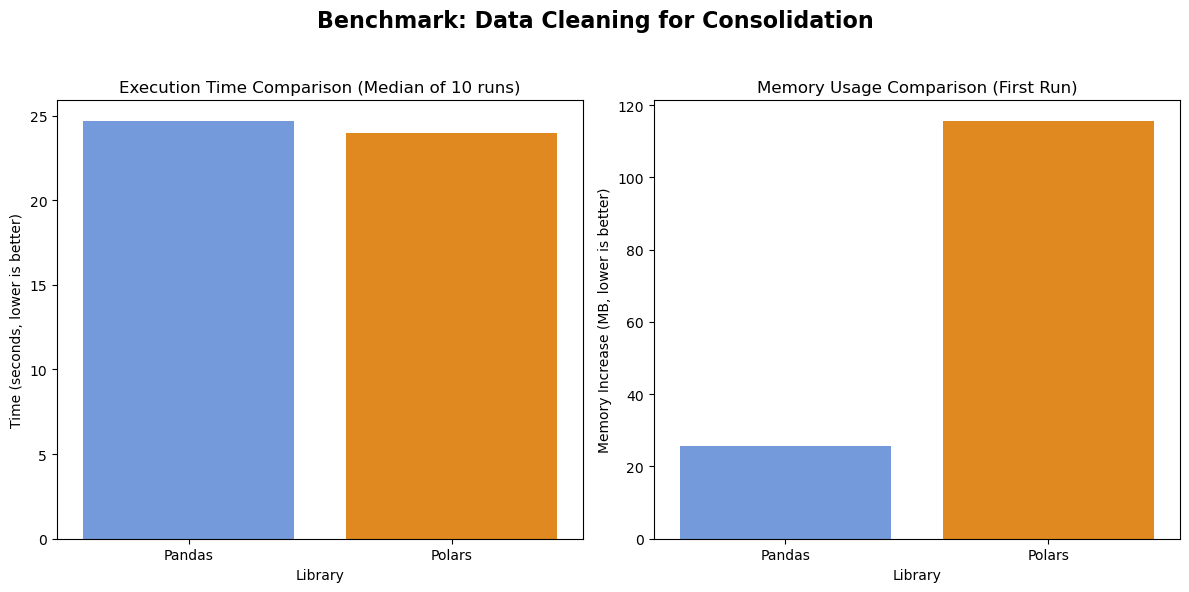

In [42]:
# --- 5. VISUALIZE BENCHMARK RESULTS ---

# This 'if' block checks that 'summary_df' was successfully created
if 'summary_df' in locals():
    
    # Define the requested color theme
    custom_palette = {
        "Pandas": "cornflowerblue", 
        "Polars": "darkorange"
    }
    
    # Create the plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Title
    fig.suptitle("Benchmark: Data Cleaning for Consolidation", fontsize=16, fontweight='bold')
    
    # --- Plot 1: Time ---
    sns.barplot(data=summary_df, x="Library", y="Time (s)", ax=axes[0], palette=custom_palette)
    axes[0].set_title("Execution Time Comparison (Median of 10 runs)")
    axes[0].set_ylabel("Time (seconds, lower is better)")
    axes[0].set_xlabel("Library")

    # --- Plot 2: Memory ---
    sns.barplot(data=summary_df, x="Library", y="Memory (MB)", ax=axes[1], palette=custom_palette)
    axes[1].set_title("Memory Usage Comparison (First Run)")
    axes[1].set_ylabel("Memory Increase (MB, lower is better)")
    axes[1].set_xlabel("Library")

    # Use tight_layout() *after* suptitle to make room
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # rect=[0, 0, 1, 0.95] adds padding for the title
    plt.show()
else:
    print("Could not generate plots. 'summary_df' not found or is empty.")

In [44]:
# --- Export Final DataFrames ---
print("Exporting final DataFrames for inspection...")

# 1. Process and export the Pandas result
print("Processing with Pandas for export...")
pandas_df = process_with_pandas()
pandas_output_path = "../Output/cleaned_reviews_pandas.csv"

# Set index=True to include the DataFrame's index
pandas_df.to_csv(pandas_output_path, index=True, index_label="id", encoding='utf-8-sig') # <-- CHANGED
print(f"Exported Pandas result ({len(pandas_df)} rows) to: {pandas_output_path}")

# 2. Process and export the Polars result
print("Processing with Polars for export...")
polars_df = process_with_polars()

# Create a new DataFrame where the review_date column is cast to a Date type
polars_df = polars_df.with_columns(pl.col("review_date").cast(pl.Date))

# Add a new column named "id" with the row number (starts from 0)
polars_df = polars_df.with_row_index("id")

polars_output_path = "../Output/cleaned_reviews_polars.csv"

polars_df.write_csv(polars_output_path, include_bom=True)
print(f"Exported Polars result ({len(polars_df)} rows) to: {polars_output_path}")

Exporting final DataFrames for inspection...
Processing with Pandas for export...
Exported Pandas result (27392 rows) to: ../Output/cleaned_reviews_pandas.csv
Processing with Polars for export...
Exported Polars result (27392 rows) to: ../Output/cleaned_reviews_polars.csv


#### Observation 1: See "clean_review_text_pl" within "clean_tripadvisor_pl" and "clean_booking_com_pl"
- Polars’ pl.concat_str function propagates nulls; if any of the input columns for a given row contained a null, the entire concatenated output for that row became null. The Pandas implementation was immune to this, as its string joining operation implicitly treats nulls as empty strings.
- This unintended generation of thousands of null review_text entries had a severe downstream effect on the deduplication step, causing thousands of distinct reviews to be incorrectly flagged as duplicates of each other. 
- The issue was rectified by explicitly adding a .fill_null("") operation before concatenation in the Polars pipeline. This finding serves as a critical illustration of how subtle differences in library-level defaults can significantly impact data integrity, underscoring the importance of explicit null handling in any data processing workflow.
  
#### Observation 2: See "review_date" = "1900"
- A limitation of the final dataset pertains to the review_date column for reviews sourced from TripAdvisor. This review_date column exhibited significant format heterogeneity, containing multiple ambiguous date representations (e.g., MM/DD/YY, Month Day, Month Day, YYYY).
- Despite implementing a robust, multi-format parsing strategy designed to handle significant date heterogeneity, a small subset of 72 records contained highly irregular or malformed date strings (year showing 1900 in the output despite input year is in 2025) that could not be reliably converted.
- Given that this represents a statistically insignificant portion of the total dataset (27 out of 27392 records), the impact on the overall analytical results is considered negligible.

In [45]:
# --- 5A. PANDAS FINAL SUMMARY STATISTICS ---

# Check if final_df exists and is not empty before proceeding
if 'pandas_df' in locals() and not pandas_df.empty:

    # ==========================================================
    # Part 1: Data Completeness Summary (Null vs. Not Null)
    # ==========================================================
    print("\n" + "="*60)
    print("PANDAS: DATA COMPLETENESS SUMMARY")
    print("="*60)
    
    # Create a DataFrame to hold the summary statistics
    summary_stats = pd.DataFrame({
        'Not Null Count': pandas_df.notnull().sum(),
        'Null Count': pandas_df.isnull().sum(),
        'Total': len(pandas_df)
    })
    
    # Calculate the percentage of missing and populated values
    summary_stats['% Populated'] = round((summary_stats['Not Null Count'] / summary_stats['Total']) * 100, 2)
    summary_stats['% Missing'] = round((summary_stats['Null Count'] / summary_stats['Total']) * 100, 2)
    
    print(summary_stats)
    
    # ==========================================================
    # Part 2: Top 10 Value Counts for Each Column
    # ==========================================================
    print("\n" + "="*60)
    print("PANDAS: TOP 10 VALUE COUNTS FOR EACH COLUMN")
    print("="*60)
    
    # Loop through each column in the DataFrame
    for column in pandas_df.columns:
        print(f"\n--- Top 10 for: {column} ---")
        
        # Calculate and print the top 10 value counts
        print(pandas_df[column].value_counts().head(10))
        
    print("\n" + "="*60)
    
else:
    print("\n'final_df' not found or is empty. Cannot generate summary stats.")



PANDAS: DATA COMPLETENESS SUMMARY
                  Not Null Count  Null Count  Total  % Populated  % Missing
source                     27392           0  27392       100.00       0.00
reviewer_name              27391           1  27392       100.00       0.00
review_text                27387           5  27392        99.98       0.02
review_score               27390           2  27392        99.99       0.01
review_date                27389           3  27392        99.99       0.01
stay_date                  22291        5101  27392        81.38      18.62
reviewer_country           19539        7853  27392        71.33      28.67
room_type                  19325        8067  27392        70.55      29.45
number_of_nights           18896        8496  27392        68.98      31.02
traveler_type              22411        4981  27392        81.82      18.18
room_category              27392           0  27392       100.00       0.00
room_view                  27392           0  27392  

In [23]:
# --- 5B. POLARS FINAL SUMMARY STATISTICS ---

if 'polars_df' in locals() and not polars_df.is_empty():

    # ==========================================================
    # Part 1: Data Completeness Summary (Null vs. Not Null)
    # ==========================================================
    print("\n" + "="*60)
    print("POLARS: DATA COMPLETENESS SUMMARY")
    print("="*60)
    
    summary_list = []
    total_rows = len(polars_df)
    
    for col_name in polars_df.columns:
        null_count = polars_df[col_name].is_null().sum()
        not_null_count = total_rows - null_count
        summary_list.append({
            "Column": col_name,
            "Not Null Count": not_null_count,
            "Null Count": null_count,
            "Total": total_rows,
            "% Populated": round((not_null_count / total_rows) * 100, 2),
            "% Missing": round((null_count / total_rows) * 100, 2)
        })
        
    summary_stats_pl = pl.DataFrame(summary_list)
    pl.Config.set_tbl_rows(-1)
    print(summary_stats_pl)
    
    # ==========================================================
    # Part 2: Top 10 Value Counts for Each Column
    # ==========================================================
    print("\n" + "="*60)
    print("POLARS: TOP 10 VALUE COUNTS FOR EACH COLUMN")
    print("="*60)
    
    for column in polars_df.columns:
        print(f"\n--- Top 10 for: {column} ---")
        
        try:
            # FIX: Changed .sort("counts") to .sort("count")
            print(polars_df[column].value_counts().sort("count", descending=True).head(10))
        except Exception as e:
            print(f"Could not get value_counts for this column. Error: {e}")
            
    print("\n" + "="*60)

else:
    print("\n'polars_df' not found or is empty. Cannot generate summary stats.")


POLARS: DATA COMPLETENESS SUMMARY
shape: (13, 6)
┌──────────────────┬────────────────┬────────────┬───────┬─────────────┬───────────┐
│ Column           ┆ Not Null Count ┆ Null Count ┆ Total ┆ % Populated ┆ % Missing │
│ ---              ┆ ---            ┆ ---        ┆ ---   ┆ ---         ┆ ---       │
│ str              ┆ i64            ┆ i64        ┆ i64   ┆ f64         ┆ f64       │
╞══════════════════╪════════════════╪════════════╪═══════╪═════════════╪═══════════╡
│ id               ┆ 27392          ┆ 0          ┆ 27392 ┆ 100.0       ┆ 0.0       │
│ source           ┆ 27392          ┆ 0          ┆ 27392 ┆ 100.0       ┆ 0.0       │
│ reviewer_name    ┆ 27391          ┆ 1          ┆ 27392 ┆ 100.0       ┆ 0.0       │
│ review_text      ┆ 27387          ┆ 5          ┆ 27392 ┆ 99.98       ┆ 0.02      │
│ review_score     ┆ 27390          ┆ 2          ┆ 27392 ┆ 99.99       ┆ 0.01      │
│ review_date      ┆ 27346          ┆ 46         ┆ 27392 ┆ 99.83       ┆ 0.17      │
│ stay_date    